## Basis Function Regression

Este ejercio toma como base la informacion del rendimiento de estudiantes para la asignatura de Matematicas.
Las fuentes de informacion tomadas sera desde el portal 
https://archive.ics.uci.edu/dataset/320/student+performance

Si se desea descarga la fuente, puede lanzar el siguiente codigo en python.
from ucimlrepo import fetch_ucirepo 
pip install ucimlrepo
student_performance = fetch_ucirepo(id=320)  
X = student_performance.data.features 
y = student_performance.data.targets   
print(student_performance.metadata) 
print(student_performance.variables) 




$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

## Importar librerias
Las siguientes lineas listan las librerias utilizadas en el desarrollo


In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os
import math
import openpyxl
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline


## Carga de datos 
Para este bloque de codigo se tomara información de archivos cvs o excel, el codigo esta preparado para la carga

Parametros : Nombre del archivo y el tipo 
Retorna: Un Dataframe

In [130]:
def Load_Data(File, tipo):
    """Carga un archivo CSV (tipo=1) o Excel (tipo!=1)."""
    if tipo == 1:
        return pd.read_csv(File, sep=';')
    else:
        return pd.read_excel(File)

def Load_Data_FeatureTarget(Namex, Namey, File, tipo):
    """Carga datos y retorna X (Namex) y Y binarizada (>=10)."""
    df = Load_Data(File, tipo)
    print("Cargando datos de:", File)

    # Validar columnas
    for col in Namex + [Namey]:
        if col not in df.columns:
            raise ValueError(f"La columna '{col}' no existe en el archivo.")

    X = df[Namex]
    y = (df[Namey] >= 10).astype(int)
    return X, y

## Construcción matematica de las funciones

El siguiente espacio de codigo genera la formulacion matematica para las regresiones lineales basadas en funciones Power function, Sinusoidal, Gaussian
Este codigo es generado con algoritmia y no hace uso de librerias de ML

### Power Function -----> $ y = x^{n-1} $
### Sinusoidal -----> $ y = sin((k-1)*wx) $
### Gaussian -----> $ f(x) = a \, e^{-\frac{(x - b)^2}{2c^2}} $
### Sigmoid function -----> $ S(x) = frac{1}{1 + e^{-x}} $

In [168]:
#. Funcion de regresión lineal de polynomial
def f_Potencia(x_n, c_k):
    return x_n ** c_k -1

# funciones de regresión lineal de Gaussianas
def f_Gaussiana(x_n, c_k, sigma=0.1):
    return math.exp(-((x_n - c_k) ** 2) / (2 * sigma ** 2))

# función de regresión lineal sigmoide desplazada
def f_Sigmoide(x_n, c_k):  
    return 1 / (1 + math.exp(- (x_n - c_k)))    

def call_function(func_name, x_base, x_train, y_train, K):
   
    # Diccionario de funciones disponibles
    functions = {
        'Potencia': f_Potencia,
        'Gaussiana': f_Gaussiana,
        'Sigmoide': f_Sigmoide
    }
    
    if func_name not in functions:
        raise ValueError(f"La función '{func_name}' no está definida.")
    
    func = functions[func_name]

    # Si x es multidimensional, tomar solo una columna para la base
    if x_train.ndim > 1 and x_train.shape[1] > 1:
        x_train_1d = x_train[:, 0]
        x_base_1d = x_base[:, 0]
    else:
        x_train_1d = x_train
        x_base_1d = x_base

    # Matriz Phi para entrenamiento
    N = len(x_train_1d)
    Phi = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            Phi[n, k] = func(x_train_1d[n], k)
    
    # Calcular pesos con pseudoinversa
    w = np.linalg.pinv(Phi) @ y_train

    # Matriz Phi para predicción
    N_test = len(x_base_1d)
    Phi_base = np.zeros((N_test, K))
    for n in range(N_test):
        for k in range(K):
            Phi_base[n, k] = func(x_base_1d[n], k)

    yhat = Phi_base @ w
    return yhat, w

In [166]:

def potencia_transform(X, K=7):
    """Genera características tipo x^k - 1 para cada variable."""
    N, D = X.shape
    features = []
    for d in range(D):
        for k in range(K):
            features.append(X[:, d] ** k - 1)
    return np.column_stack(features)

def gaussiana_transform(X, K=7, sigma=0.1):
    """Genera características gaussianas exp(-((x - c)^2) / (2*sigma^2))."""
    N, D = X.shape
    features = []
    for d in range(D):
        for k in range(K):
            features.append(np.exp(-((X[:, d] - k) ** 2) / (2 * sigma ** 2)))
    return np.column_stack(features)

def sigmoide_transform(X, K=7):
    """Genera características sigmoides 1 / (1 + exp(-(x - c)))."""
    N, D = X.shape
    features = []
    for d in range(D):
        for k in range(K):
            features.append(1 / (1 + np.exp(-(X[:, d] - k))))
    return np.column_stack(features)


### Metodo Principal sin sklearn
##### Parametros 
File:  Nombre y ruta del archivo a procesas  ejemplo File =  'data/student-mat.csv'

Namex:  Varible que contrendra el Feature.   Ejemplo NameX= 'studytime'

Namey:  Variable que almacena el target  Ejemplo  Namey= 'G3'

Listado de funciones implementadas 

function = 'Gaussiana'
  functions = {
        'Potencia': f_Potencia,
        'Gaussiana': f_Gaussiana,
        'Sigmoide': f_Sigmoide
    }

Cargando datos de: data/student-mat.csv
x_base: (395, 3)
y_base: (395,)


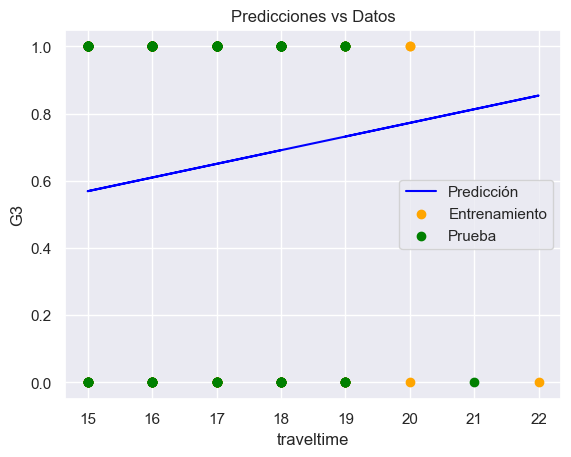

In [169]:
if __name__ == "__main__":
    File = "data/student-mat.csv"
    #Namex = ['age', 'absences','traveltime',	'studytime','failures','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']
    Namex = ['age', 'absences','traveltime']
    Namey = 'G3'
    function = 'Potencia'  # Cambiar a 'Potencia' o 'Gaussiana' si se desea
    K = 2
    alpha = 0.7
    # Cargar datos
    x_base, y_base = Load_Data_FeatureTarget(Namex, Namey, File, 1)
    print(f"x_base: {x_base.shape}")
    print(f"y_base: {y_base.shape}")

    # Convertir a numpy arrays
    x_base = np.array(x_base)
    y_base = np.array(y_base)

    # Dividir en entrenamiento y prueba
    idx = np.random.permutation(len(x_base))
    train_size = round(alpha * len(x_base))
    x_train = x_base[idx[:train_size]]
    y_train = y_base[idx[:train_size]]
    x_test = x_base[idx[train_size:]]
    y_test = y_base[idx[train_size:]]

    # Entrenar y predecir
    yhattrain, wtrain = call_function(function, x_base, x_train, y_train, K)

    # Graficar
    plt.plot(x_base[:, 0], yhattrain, color='blue', label='Predicción')
    plt.scatter(x_train[:, 0], y_train, color='orange', label='Entrenamiento')
    plt.scatter(x_test[:, 0], y_test, color='green', label='Prueba')
    plt.xlabel(Namex[2])
    plt.ylabel(Namey)
    plt.title('Predicciones vs Datos')
    plt.legend()
    plt.show()

### Metodo Principal con sklearn
##### Parametros 
File:  Nombre y ruta del archivo a procesas  ejemplo File =  'data/student-mat.csv'

Namex:  Varible que contrendra el Feature.   Ejemplo NameX= 'studytime'

Namey:  Variable que almacena el target  Ejemplo  Namey= 'G3'

Listado de funciones implementadas 

function = 'Gaussiana'
  functions = {
        'Potencia': f_Potencia,
        'Gaussiana': f_Gaussiana,
        'Sigmoide': f_Sigmoide
    }

Cargando datos de: data/student-mat.csv
x_base: (395, 3)
y_base: (395,)


/Users/carlosandresarroyaveoutlook.com/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/carlosandresarroyaveoutlook.com/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/carlosandresarroyaveoutlook.com/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


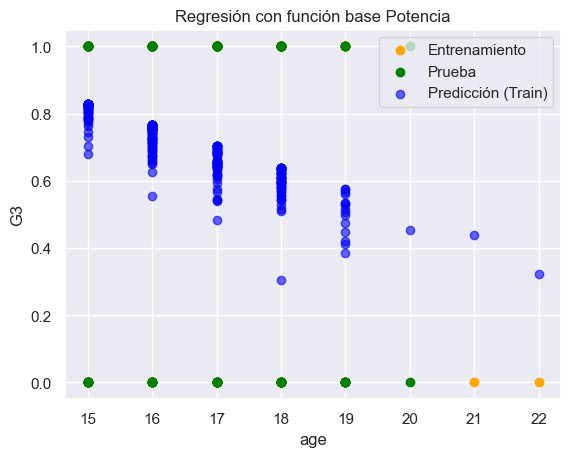

In [170]:

if __name__ == "__main__":
    File = "data/student-mat.csv"
    #Namex = ['age', 'absences','traveltime',	'studytime','failures','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']
    Namex = ['age', 'absences','traveltime']
    Namey = 'G3'
    function = 'Potencia'  # Cambiar a 'Potencia' o 'Gaussiana' si se desea
    K = 2
    alpha = 0.7
    # Cargar datos
    x_base, y_base = Load_Data_FeatureTarget(Namex, Namey, File, 1)
    print(f"x_base: {x_base.shape}")
    print(f"y_base: {y_base.shape}")

    # Convertir a numpy arrays
    x_base = np.array(x_base)
    y_base = np.array(y_base)

    # Dividir en entrenamiento y prueba
    idx = np.random.permutation(len(x_base))
    train_size = round(alpha * len(x_base))
    x_train = x_base[idx[:train_size]]
    y_train = y_base[idx[:train_size]]
    x_test = x_base[idx[train_size:]]
    y_test = y_base[idx[train_size:]]
   

    # Elegir transformador
    if function == "Potencia":
        transformer = FunctionTransformer(lambda x_base: potencia_transform(x_base, K), validate=False)
    elif function == "Gaussiana":
        transformer = FunctionTransformer(lambda x_base: gaussiana_transform(x_base, K), validate=False)
    elif function == "Sigmoide":
        transformer = FunctionTransformer(lambda x_base: sigmoide_transform(x_base, K), validate=True)
    else:
        raise ValueError("Función no reconocida")

    # Crear pipeline y entrenar
    model = Pipeline([
        ("features", transformer),
        ("regressor", LinearRegression())
    ])

    model.fit(x_train, y_train)

    # Predicción
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    # Gráfico (solo primera variable para visualización)
    plt.scatter(x_train[:, 0], y_train, color='orange', label='Entrenamiento')
    plt.scatter(x_test[:, 0], y_test, color='green', label='Prueba')
    plt.scatter(x_train[:, 0], y_pred_train, color='blue', label='Predicción (Train)', alpha=0.6)
    plt.xlabel(Namex[0])
    plt.ylabel(Namey)
    plt.title(f"Regresión con función base {function}")
    plt.legend()
    plt.show()